### To do list
todo:
- make debug function that logs errors
- make mel matrix 
- make spec col

### Set working directory

In [2]:
# Import the os module
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir('/vol/tensusers2/aliesenfeld/Elpaco dataset/')
#os.chdir('/Users/u517177/continuer_paper/')


# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /vol/tensusers2/aliesenfeld/Elpaco dataset
Current working directory: /vol/tensusers2/aliesenfeld/Elpaco dataset


# Part 1: audio extraction

### Dependencies


In [3]:
#on M1 mac librosa needs to be installed via miniforge
#!conda install -c conda-forge librosa
import wave
import IPython
import librosa
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

/tmp/ipykernel_1354822/732630340.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
#install tensorflow if needed

#!conda install -c conda-forge tensorflow -y
#!pip install tensorflow-macos

'Elpaco dataset'/              output/         streaks_10perlang.csv
'continuer data'/              output_trail/   streaks_1perlang.csv
 continuers_for_audio.csv      streaks/        streaks_50perlang.csv
 discontinuers_for_audio.csv   streaks.csv     zic1z6cK


### Inspect single audio files

In [3]:
#Load and inspect single files
audiofile = wave.open('./Elpaco dataset/akhoe_haikom1/state_hospital.wav','r')

print( "Number of channels",audiofile.getnchannels())
print ( "Sample width",audiofile.getsampwidth())
print ( "Frame rate.",audiofile.getframerate())
print ("Number of frames",audiofile.getnframes())
print ( "parameters:",audiofile.getparams())

Number of channels 2
Sample width 2
Frame rate. 48000
Number of frames 73200000
parameters: _wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=73200000, comptype='NONE', compname='not compressed')


In [ ]:
#play audio files
IPython.display.Audio('./Elpaco dataset/akhoe_haikom1/state_hospital.wav')

### read csv

In [4]:
#read csv 
df_audio = pd.read_csv('continuers_for_audio.csv')
df_audio

,uid,language,begin,end,duration,source,participant,utterance_stripped,utterance,form_ascii
0,akhoe_haikom-2-194-371425,akhoe_haikom,371.425,371.725,300.0,/akhoe_haikom1/state_hospital,tx@Es,î,î,i_
1,akhoe_haikom-2-203-398335,akhoe_haikom,398.335,398.545,210.0,/akhoe_haikom1/state_hospital,tx@Es,î,î,i_
2,akhoe_haikom-2-457-1245412,akhoe_haikom,1245.412,1245.780,368.0,/akhoe_haikom1/state_hospital,tx@Ga,î,î,i_
3,akhoe_haikom-2-459-1247720,akhoe_haikom,1247.720,1248.010,290.0,/akhoe_haikom1/state_hospital,tx@Ga,î,î,i_
4,akhoe_haikom-2-482-1290491,akhoe_haikom,1290.491,1290.851,360.0,/akhoe_haikom1/state_hospital,tx@Ga,î,î,i_
...,...,...,...,...,...,...,...,...,...,...
139546,zaar-2-142-181303,zaar,181.303,181.672,369.0,/zaar1/SAY_BC_CONV_02,tx@SP1,tôː,tôː,to_ː
139547,zaar-2-367-449687,zaar,449.687,450.145,458.0,/zaar1/SAY_BC_CONV_02,tx@SP1,m̀ː,m̀ː,m_ː
139548,zaar-2-368-450762,zaar,450.762,451.085,323.0,/zaar1/SAY_BC_CONV_02,tx@SP1,m̀ː,m̀ː,m_ː
139549,zaar-3-459-440411,zaar,440.411,440.985,574.0,/zaar1/SAY_BC_CONV_03,tx@SP2,m̀ː,m̀ː,m_ː


### Preprocess csv

In [ ]:
#Optional:
#check timestamp format and .div is needed to match audio extaction function requirements
df_audio['begin'] = df_audio['begin'].div(1000)
df_audio['end'] = df_audio['end'].div(1000)
df_audio

In [38]:
#drop czech because it has separate speaker channels
df_audio = df_audio[df_audio.language != "czech"]

#exclude corpora without audio files
df_audio = df_audio[df_audio.language != "italian"]
df_audio = df_audio[df_audio.language != "zacatepec_chatino"]

#drop files without audio

df_audio.dropna(subset=['begin','end'], inplace=True)
df_audio = df_audio.groupby(['source']).apply(lambda x: x.sample(1, replace=True)).reset_index(drop=True)

df_audio

,uid,language,begin,end,duration,source,participant,utterance_stripped,utterance,form_ascii
0,akhoe_haikom-2-494-1312920,akhoe_haikom,1312.920,1313.280,360.0,/akhoe_haikom1/state_hospital,tx@Ga,î,î,i_
1,akie-1-033-99525,akie,99.525,100.289,764.0,/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo,B,aá,aá,aa_
2,ambel-3-147-222600,ambel,222.600,223.085,485.0,/ambel1/AM064,ESD_Transcription-txt-wgo,ii,ii,ii
3,ambel-4-470-662638,ambel,662.638,663.212,574.0,/ambel1/AM067,WG_Transcription-txt-wgo,mm,mm,mm
4,anal-01-098-184010,anal,184.010,184.379,369.0,/anal1/anm_20160916_PO_Wolring_1,Anal sp3,mm,mm,mm
...,...,...,...,...,...,...,...,...,...,...
851,yeli_dnye-1-457-1355836,yeli_dnye,1355.836,1356.486,650.0,/yeli_dnye1/r03_v19_s2,K,nyââ,[unk_utterance]nyââ,nya_â
852,yeli_dnye-2-129-591369,yeli_dnye,591.369,591.989,620.0,/yeli_dnye1/r03_v20_s5,Kp,mm,mm,mm
853,yeli_dnye-3-113-151660,yeli_dnye,151.660,151.920,260.0,/yeli_dnye1/r03_v21_s1,James,nyââ,nyââ,nya_â
854,zaar-2-368-450762,zaar,450.762,451.085,323.0,/zaar1/SAY_BC_CONV_02,tx@SP1,m̀ː,m̀ː,m_ː


### `read_audio` function

In [ ]:
def get_row_audio(df_audio, wav_loc):
    """ load audio and grab individual turns
    TODO: for large sparse WAV files, the audio should be loaded only for the turn
    """
    
    #print path to audio file (optional)
    print(wav_loc)

    # load audio
    try:
        #Three options here, comment out as needed:

        #scipy wavfile
        #rate, data = wavfile.read(wav_loc)
        
        #librosa
        rate, data = librosa.load(wav_loc)
        
        #base python
        #rate, data = wave.open(wav_loc)

        #explore fourth option: use ffmpeg directly 
        #ffmpeg?

        data = data.astype('float32')
        
        # get audio for each turn
        df_audio["audio"] = [
            data[int(st * rate) : int(et * rate)].copy(deep=True)
            for st, et in zip(df_audio.begin.values, df_audio.end.values)
        ]

        df_audio["rate"] = rate
    except Exception:
        pass

    return df_audio

### Loops for execution

In [ ]:
#execute as for loop
[get_row_audio(df_audio[df_audio.source == source], './Elpaco dataset'+ source +'.wav') for source in df_audio.source]

In [ ]:
#execute using parallel 

with Parallel(n_jobs=1, verbose=verbosity) as parallel:
    df_audios = parallel(
        delayed(get_row_audio)(
            df_audio[df_audio.source == source], 
            './Elpaco dataset'+ source +'.wav', #Edit path to corpus directory here
        )
        for source in tqdm(df_audio.source)
    )
df_audio = pd.concat(df_audios)
len(df_audio)

### Normalize audio  (optional)

In [9]:
# normalize audio if needed
df_audio['audio'] = [librosa.util.normalize(i) for i in df_audio.audio.values]

### Plot `audio` column waveforms

  5%|▍         | 11/240 [00:00<00:00, 254.29it/s]


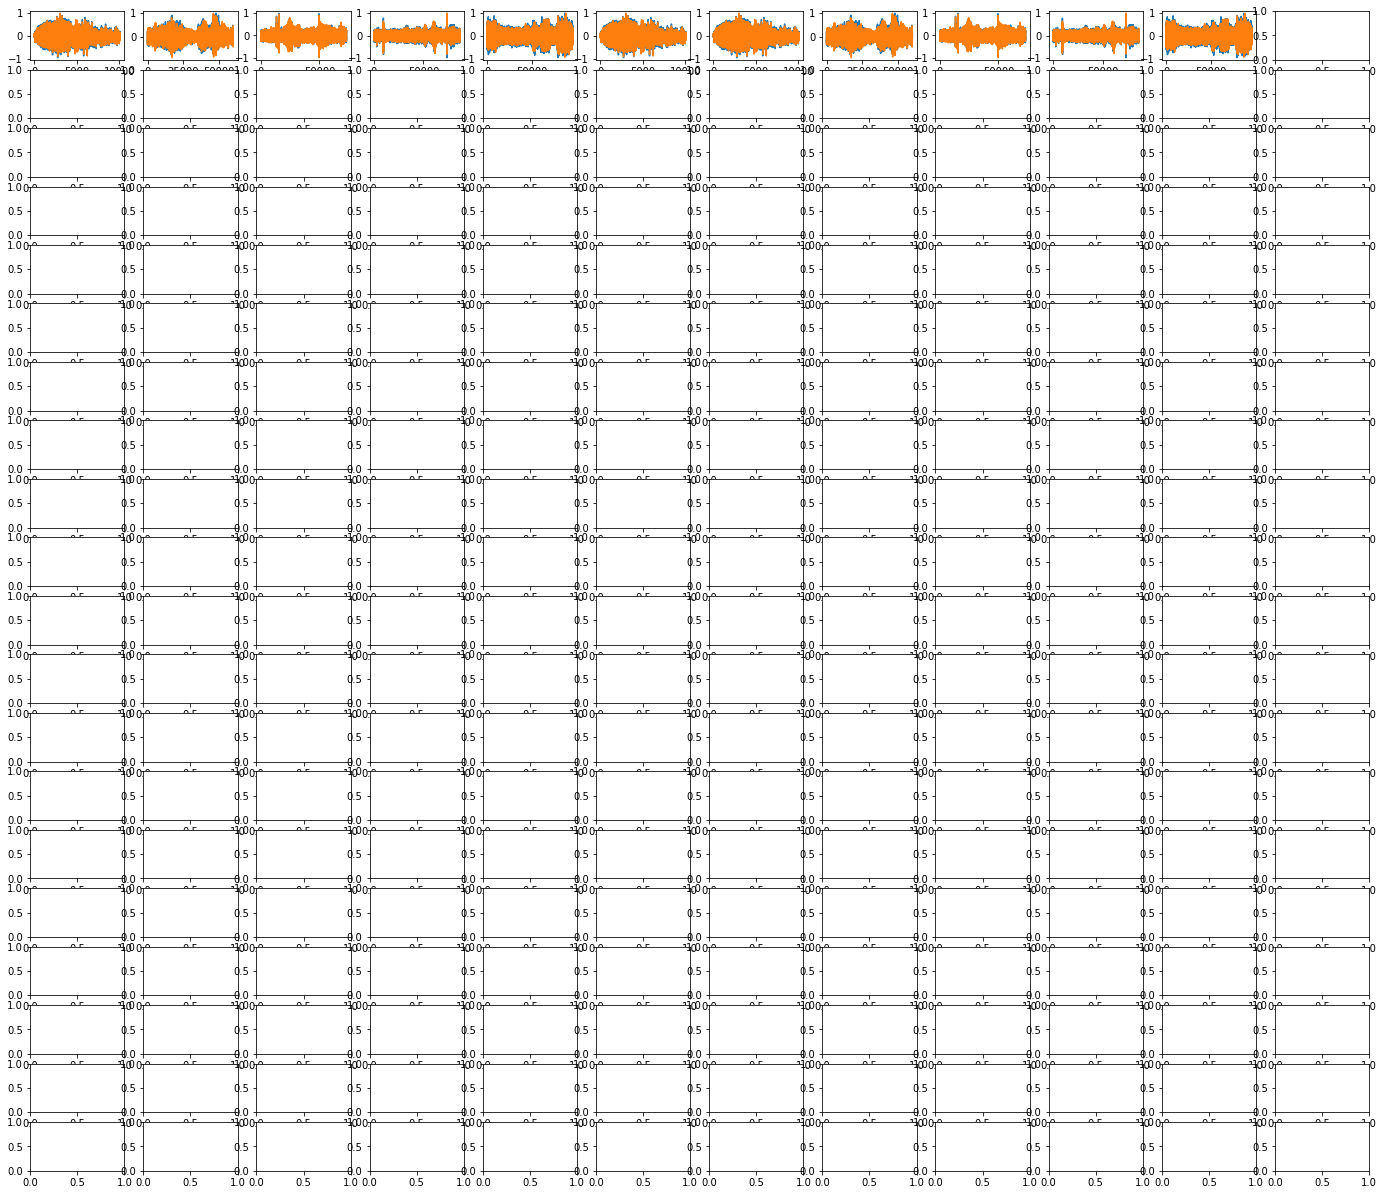

In [10]:
# plot some example audio 
nrows = 20
ncols = 12
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, turn in tqdm(enumerate(df_audio['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(turn)
    if i == nrows*ncols -1:
        break

### Save as `csv`

In [3]:
df_audio.to_csv("df_audio.csv", index=False)
df_audio

NameError: name 'df_audio' is not defined